In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()  

    
        

In [3]:
def normalized_cross_correlation(im_1, im_2):
    """
    Computes the normalized cross correlation between two images.
    """
    im_1_mean = np.mean(im_1)
    im_2_mean = np.mean(im_2)

    norm = np.sqrt(
                np.sum(np.power(im_2 - im_2_mean, 2))
                * np.sum(np.power(im_1 - im_2_mean, 2))
            )

    return np.sum(np.multiply(im_2 - im_2_mean, im_1 - im_1_mean)) / norm
    

In [4]:
def draw_rectangle_at_detection(image, template_shape, detection_positions):
    detection_positions = zip(detection_positions[0], detection_positions[1])
    for detection_position in detection_positions:
        cv.rectangle(
            image,
            (detection_position[1], detection_position[0]),
            (detection_position[1] + template_shape[1], detection_position[0] + template_shape[0]),
            0
        )
    return image

In [5]:
def templ_matching_nxc(image, template):
    """
    Computes the normalized cross correlation between the template and every possible location in the image.
    :param image: image to search in
    :param template: template to search for
    :return: image with the normalized cross correlation
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = normalized_cross_correlation(
                image[i : i + template_h, j : j + template_w], template
            )
    if result.min() < 0:
        result = result - result.min()
    result /= result.max()
    return result

## Task 3. Template matching multi-scale

In this task, we will build the Gaussian pyramid to make template matching work at different resolutions. 
Read the image DogGray.jpeg and the template DogTemplate.jpeg

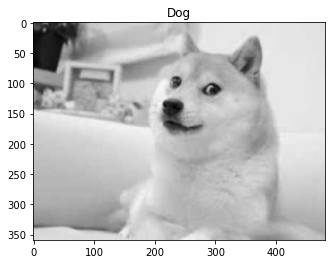

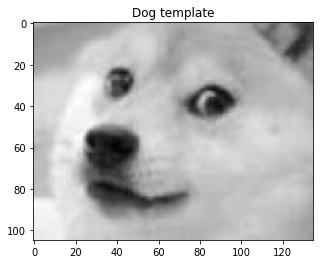

In [6]:
# set images pathes
dog_path = '../data/DogGray.jpeg'
dog_template_path = '../data/DogTemplate.jpeg'
# read imgs
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
dog_template = cv.imread(dog_template_path, cv.IMREAD_GRAYSCALE)

display_image('Dog', dog)
display_image('Dog template', dog_template)

* Build a 5 level Gaussian pyramid by downsampling input image yourself.

In [7]:
def build_gaussian_pyramid(image, num_levels):
    """
    Builds a Gaussian pyramid of an image.
    :param image: image to build the pyramid from
    :param num_levels: number of levels in the pyramid
    :return: Gaussian pyramid
    """
    pyramid = [image]
    for i in range(num_levels - 1):
        # pyramid.append(cv.pyrDown(pyramid[i]))
        blurred_image = cv.GaussianBlur(src=image, ksize=(0, 0), sigmaX=1)
        image = blurred_image[0::2, 0::2] # downsampling by 2 (even rows and columns)
        pyramid.append(image)
    return pyramid

    

* Now create a 5 level Gaussian pyramid using cv2.pyrDown. Compare it with
your implementation by printing the mean absolute difference at each level.

In [8]:
def build_gaussian_pyramid_opencv(image, num_levels):
    pyramid = [image]
    for i in range(num_levels - 1):
        pyramid.append(cv.pyrDown(pyramid[i])) 
    return pyramid

Mean absolute difference between the two images (lavel 0): 0.0
Mean absolute difference between the two images (lavel 1): 3.4180267404333793
Mean absolute difference between the two images (lavel 2): 7.099173553719008
Mean absolute difference between the two images (lavel 3): 11.850273224043717
Mean absolute difference between the two images (lavel 4): 26.189340813464234


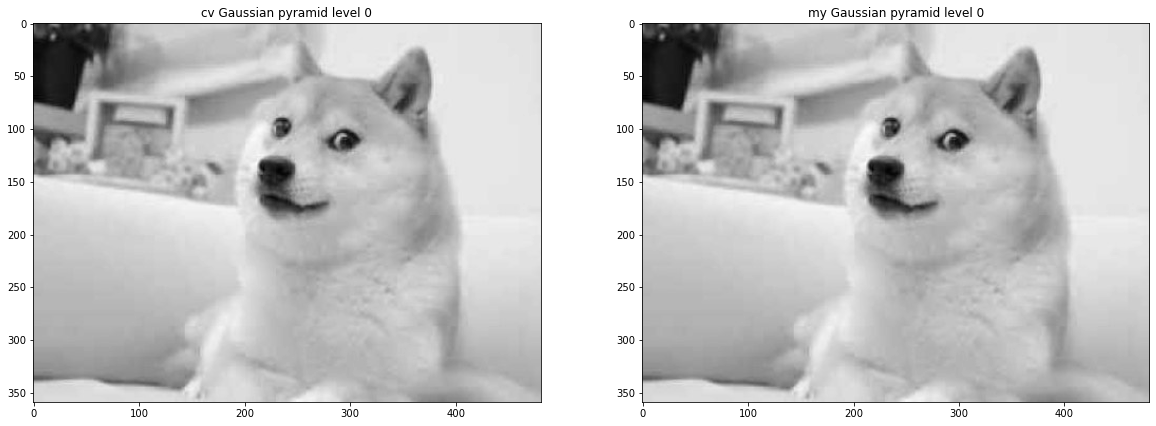

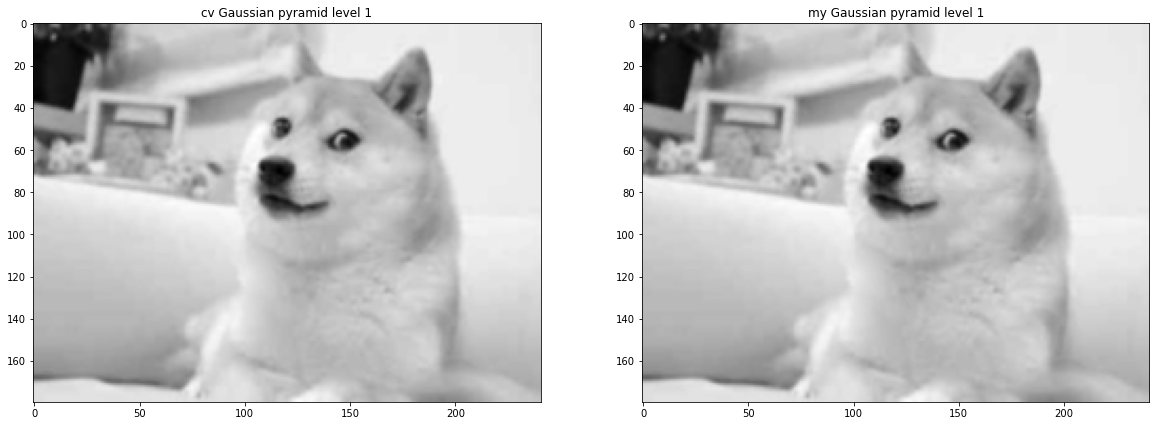

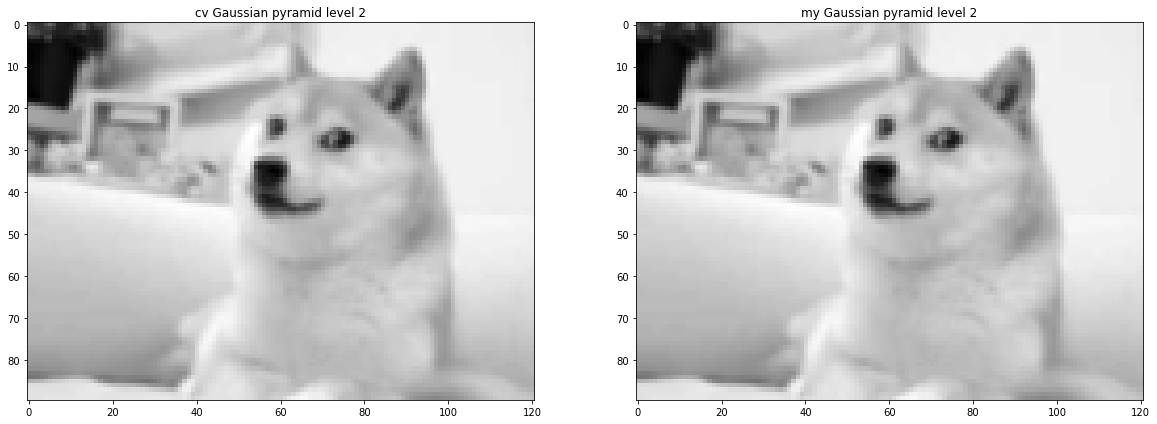

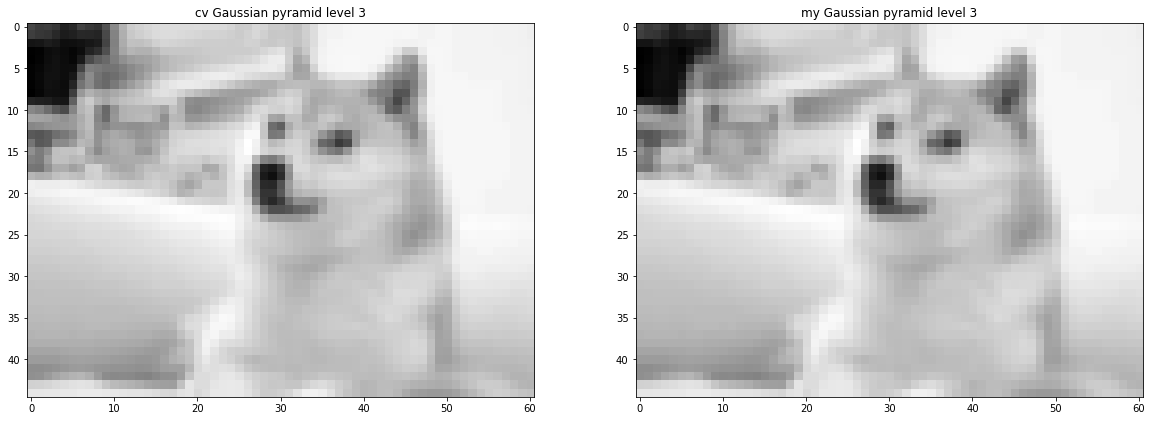

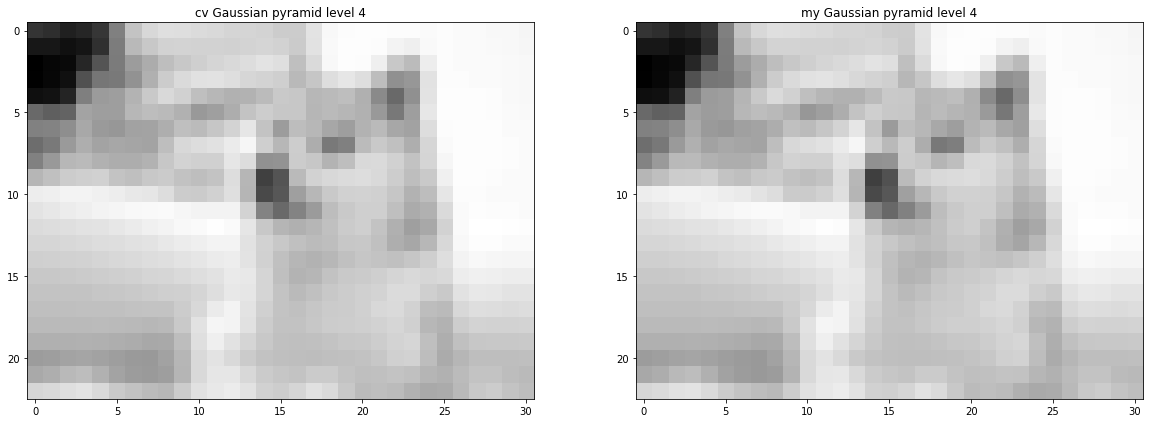

In [9]:
pyramid_my = build_gaussian_pyramid(dog, 5)
pyramid_cv = build_gaussian_pyramid_opencv(dog, 5)
for i, images in enumerate(zip(pyramid_cv, pyramid_my)):
    display_image(f'cv Gaussian pyramid level {i}', images[0], f'my Gaussian pyramid level {i}', images[1]) 
    print(f"Mean absolute difference between the two images (lavel {i}): {np.mean(np.abs(images[0] - images[1]))}")

* Perform template matching by using your implementation of normalized cross
correlation . Report the time taken by this method.

Time for NXC: 110.50393629999999 seconds


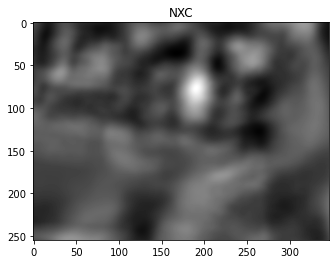

In [10]:
start = time.perf_counter()
similarity_nxc_img_ = templ_matching_nxc(dog, dog_template)
end = time.perf_counter()
print(f"Time for NXC: {end - start} seconds")
display_image('NXC', similarity_nxc_img_)

1.0


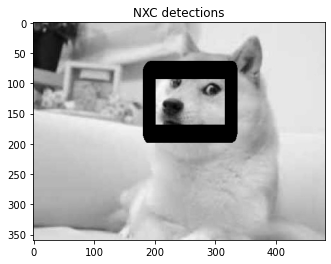

In [11]:
detections = np.where(similarity_nxc_img_ >= 0.7613)
print(similarity_nxc_img_.max(  ))
result = draw_rectangle_at_detection(dog, dog_template.shape, detections)
display_image('NXC detections', result)

* Show the template matching using normalized cross correlation at the different
Pyramid levels of both the template and input images (you can use the pyramid
obtained by pyrDown).

Time for NXC image in level 0: 110.50393629999999 seconds
Time for NXC image in level 1: 8.724334400000004 seconds
Time for NXC image in level 2: 0.8310697000000005 seconds
Time for NXC image in level 3: 0.17532470000000444 seconds
Time for NXC image in level 4: 0.04651419999999007 seconds


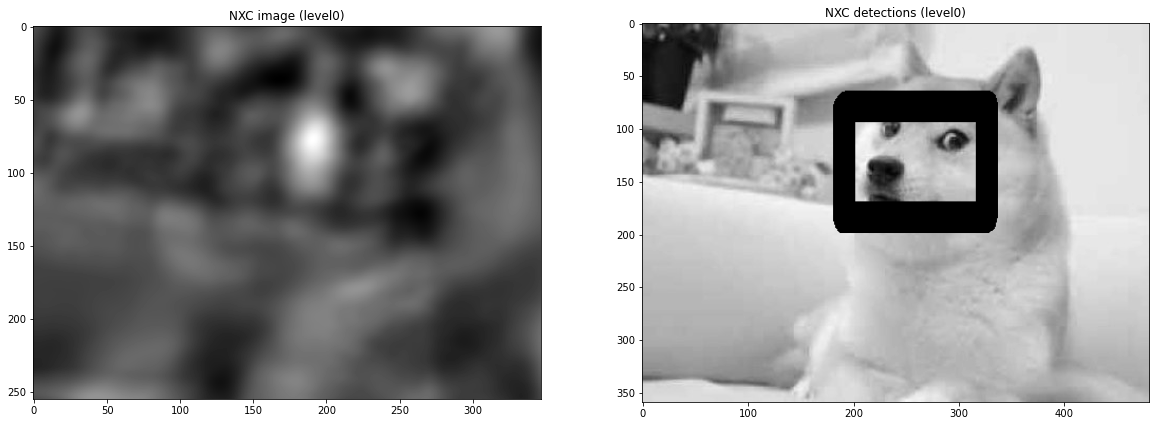

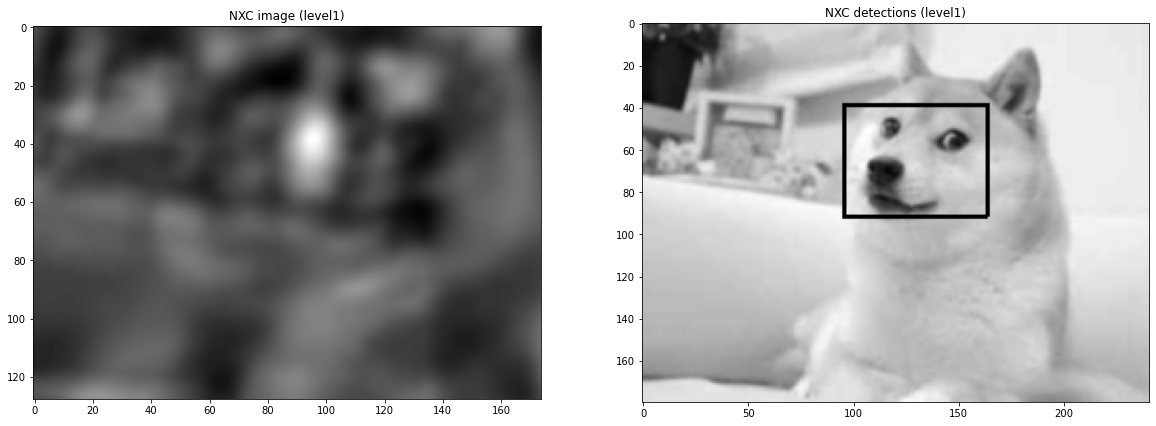

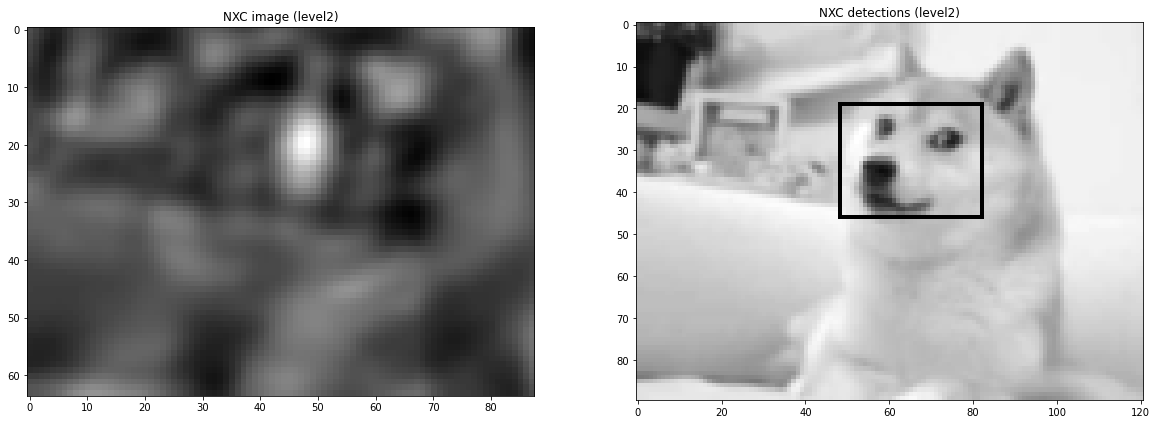

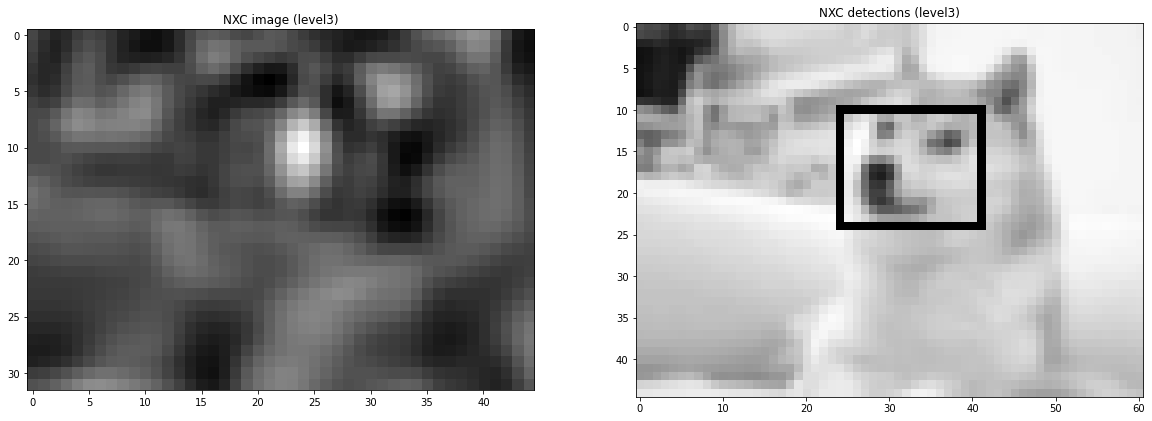

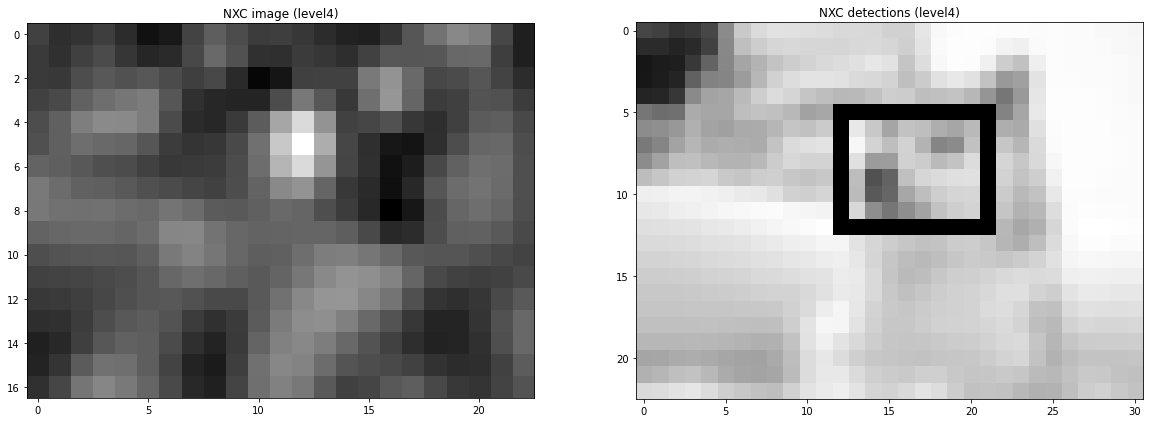

In [12]:
# pyramid_cv
pyramid_tmpl_cv = build_gaussian_pyramid_opencv(dog_template, 5)

similarity_nxc_img_arr = [similarity_nxc_img_]
time_arr = [end - start]
for i in range(1, len(pyramid_cv)):
    start = time.perf_counter()
    similarity_nxc_img_arr.append(templ_matching_nxc(pyramid_cv[i], pyramid_tmpl_cv[i]))
    end = time.perf_counter()
    time_arr.append(end - start)

for i, simil_image in enumerate(similarity_nxc_img_arr):
    detections = np.where(simil_image >= simil_image.max( ) - 0.003)
    result_ = draw_rectangle_at_detection(pyramid_cv[i], pyramid_tmpl_cv[i].shape, detections)
    display_image(f'NXC image (level{i})', simil_image, f'NXC detections (level{i})', result_)
    print(f"Time for NXC image in level {i}: {time_arr[i]} seconds")

* As you observed, implementing template matching naively is not efficient. Now
we will rely on the pyramid technique while constraining the search space in
order to make it faster. Follow the procedure described in the lecture slides:
search only in regions with high similarity in the previous pyramid level. Compare
the times taken by this method and the naive implementation.

In [13]:

def template_matching_multiple_scales(pyramid_image, pyramid_template, visualize=False):
    """
    Performs template matching on multiple scales.
    :param pyramid_image: image pyramid
    :param pyramid_template: template pyramid
    :return: similarity map
    """

    # reverse pyramid_image and pyramid_template
    pyramid_image = pyramid_image[::-1]
    pyramid_template = pyramid_template[::-1]


    similarity_img = templ_matching_nxc(pyramid_image[0], pyramid_template[0])
    if similarity_img.min() < 0:
        similarity_img = similarity_img - similarity_img.min()
    similarity_img = similarity_img / similarity_img.max()

    if visualize:
        display_image(f'NXC-multiscale similarity image (level)', similarity_img)

    threshold = 0.75
    search_window_size = 7

    for i in range(1, len(pyramid_image)):
        detection_positions = np.where(similarity_img >= threshold)
        print(f"Number of detections in level {len(pyramid_image)-i}: {len(detection_positions[0])}")
        detection_positions = zip(detection_positions[0], detection_positions[1])

        similarity_img = np.zeros_like(pyramid_image[i])

        image_height, image_width = pyramid_image[i].shape
        template_height, template_width = pyramid_template[i].shape

        
        for detection_position in detection_positions:
            
            # upscale detection position for the next level
            detection_position = [detection_position[0] * 2, detection_position[1] * 2]
            #  detection_position = [x * 2 for x in detection_position]  # match location in the higher scale
            
            # check if the detection position is in the image, if not, set it to 0
            top_left_corner = max(detection_position[0] - search_window_size, 0), max(detection_position[1] - search_window_size, 0)
            detection_position[0] += template_height
            detection_position[1] += template_width

            # check if the detection position is in the image, if not, set it to heigth/width of image
            bottom_right_corner = min(detection_position[0] + search_window_size, image_height), min(detection_position[1] + search_window_size, image_width)

            patch = pyramid_image[i][
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ]

            #display_image(f'Patch', patch)

            # calculate similarity only inside of the patch
            similarity = templ_matching_nxc(patch, pyramid_template[i]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            similarity_result = np.zeros_like(patch)

            similarity_result[:similarity.shape[0], :similarity.shape[1]] = similarity #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # similarity_result = templ_matching_nxc(patch, pyramid_template[i])
            similarity_img_patch = similarity_img[
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ]
            #print(similarity_img_patch.max( ))
            # find location of increased similarity and save as mask
            mask = np.float32(similarity_result > similarity_img_patch)
            
            # increase values of similarty_img only where mask is 1 and only in the patch lacation
            similarity_img[
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ] = (mask * similarity_result + (1 - mask) * similarity_img_patch).astype(np.uint8)

        if visualize:
            display_image(f'NXC-multiscale similarity image (level{len(pyramid_image) - i-1})', similarity_img)
            
    return similarity_img


Number of detections in level 4: 4
Number of detections in level 3: 1
Number of detections in level 2: 1
Number of detections in level 1: 1
Time for NXC multiscale: 0.8699620000000152 seconds


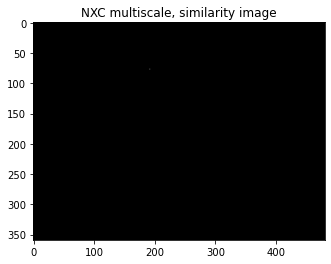

In [21]:
pyramid_cv = build_gaussian_pyramid_opencv(dog, 5)
pyramid_tmpl_cv = build_gaussian_pyramid_opencv(dog_template, 5)
start = time.perf_counter()
similarity_nxc_multiscale_img = template_matching_multiple_scales(pyramid_cv, pyramid_tmpl_cv)
end = time.perf_counter()
print(f"Time for NXC multiscale: {end - start} seconds")
display_image('NXC multiscale, similarity image', similarity_nxc_multiscale_img)

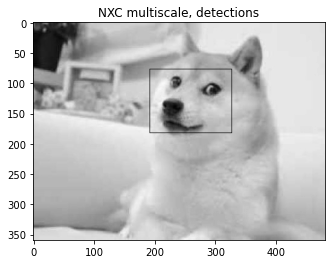

In [26]:
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
detections = np.where(similarity_nxc_multiscale_img >= 0.99)
result_multiscale_ = draw_rectangle_at_detection(dog, pyramid_tmpl_cv[0].shape, detections)
display_image('NXC multiscale, detections', result_multiscale_)

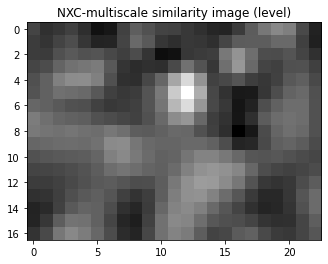

Number of detections in level 4: 4


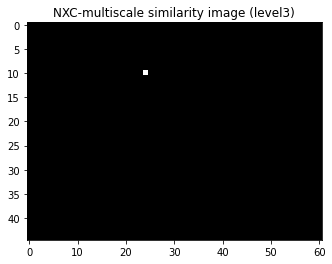

Number of detections in level 3: 1


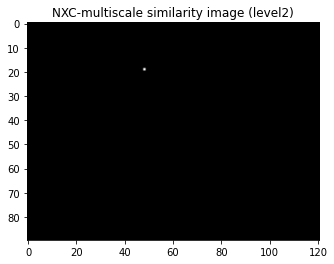

Number of detections in level 2: 1


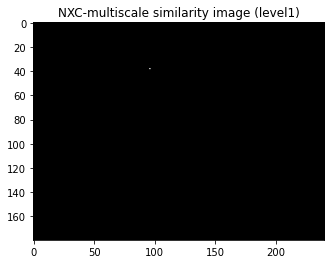

Number of detections in level 1: 1


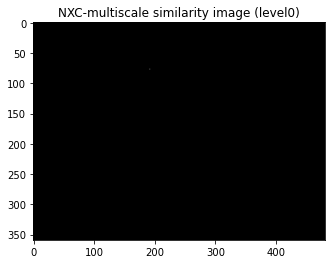

In [24]:
similarity_nxc_multiscale_img_visual = template_matching_multiple_scales(pyramid_cv, pyramid_tmpl_cv, True)
